In [ ]:
#Sentiment 140 taken from Kaggle
#Dataset Link https://drive.google.com/drive/folders/19qemULbnUZL5KeZB-Ro-AHEy_mtJCMCF?usp=sharing

In [2]:
#Set up environment
!pip uninstall torch -y
!pip install torch==1.7.1
!pip install torchtext==0.8
from google.colab import drive
import os
drive.mount('/content/gdrive', force_remount = 1)
!cp -r gdrive/MyDrive/Dataset/Twitter_Data.csv .
#Download GloVe embeddings and extract here
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip
!ls

Found existing installation: torch 1.12.1+cu113
Uninstalling torch-1.12.1+cu113:
  Successfully uninstalled torch-1.12.1+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 776.8 MB 13 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.7.1 which is incompatible.
torchtext 0.13.1 requires torch==1.12.1, but you have torch 1.7.1 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.7.1 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.9 MB 4.6 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1


Mounted at /content/gdrive
--2022-09-17 03:08:29--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2022-09-17 03:08:29--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  4.99MB/s    in 4m 45s  

2022-09-17 03:13:15 (5.09 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]

Archive:  glove.twitter.27B.zip
  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import sys # only needed to determine Python version number
import matplotlib # only needed to determine Matplotlib version 
import nltk
from nltk.stem import WordNetLemmatizer
import pprint
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from torchtext import vocab
from torchtext.data import Field,Dataset,LabelField,BucketIterator,TabularDataset # TorchText has Text processing Function
from torchtext.vocab import GloVe
import random
import os
from wordcloud import STOPWORDS as stopwords1, WordCloud
from nltk.corpus import stopwords as stopwords2
import string
import re
import warnings
from wordcloud import STOPWORDS as stopwords1,WordCloud
from nltk.corpus import stopwords as stopwords2
from nltk import word_tokenize
import unicodedata
from statistics import mean
from collections import Counter
import collections
warnings.filterwarnings("ignore")

nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [3]:
stopwords = set(stopwords1)
stopwords_nltk =  set(stopwords2.words('english'))
stopwords.update(stopwords_nltk)

# Removes stopwords from sentences
def removeStopWords(text):
    return ' '.join([y for y in word_tokenize(text) if y not in stopwords])

# Function that lemmatizes wanted columns
lemmatizer = nltk.stem.WordNetLemmatizer()
def Lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(y,'v') for y in word_tokenize(text)])

def normalazation(text):
    return ' '.join([normalize_word(y) for y in word_tokenize(text)])

def normalize_word(word):
    # Will remove the encode token by token
    word = unicodedata.normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII')
    return word

def smallwordsRemoval(text):
    return ' '.join([remove_smallWords(y) for y in word_tokenize(text)])

def remove_smallWords(word):
    if (len(word) > 2):
        return word
    else:
        return ''    

def preprocess_text(column_of_sentences):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    processed_column = [] 
    for sentence in column_of_sentences:
      processed_sentence = [] 
      for word in word_tokenize(sentence):
        if word not in string.punctuation:
          word = word.replace(r'@\S+',' ').replace(r'\\\S+',' ').replace('\n',' ').replace('[{}]'.format(string.punctuation), '')
          word = word.lower()
          word = ''.join(ch for ch in word if not ch in string.punctuation and not ch.isdigit())
          word = unicodedata.normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII')
          word = lemmatizer.lemmatize(word,'v')
          if len(word) > 2:
            processed_sentence.append(word)
      if len(processed_sentence) == 0:
        processed_column.append(np.nan)
      else:
        processed_column.append(' '.join(processed_sentence))
    return processed_column        



def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()
device = 'cuda'

In [4]:
#Dataset taken from: https://www.kaggle.com/datasets/kazanova/sentiment140
#target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
df = pd.read_csv("Twitter_Data.csv", header=None)
df = df.sample(frac=1).iloc[:1000, [0, 5]]
df.columns = ['target', "text"]

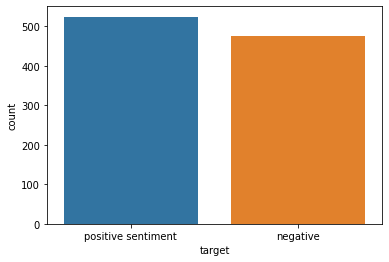

In [5]:
import seaborn as sns

temp_df = df.replace(0, "negative")
temp_df = temp_df.replace(4, "positive sentiment")
temp_df

sns.countplot(x = temp_df["target"])

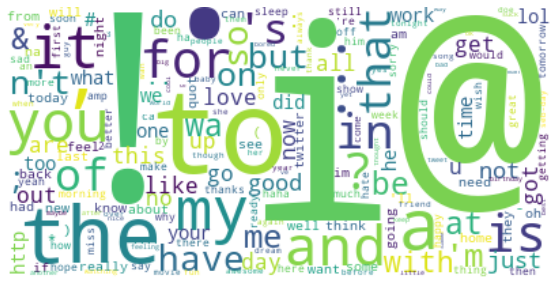

In [11]:
# Function that given a list of data will produce a WordCloud
def generate_WordCloud(data):
    textWords = []
    for x in data:
        for y in word_tokenize(x) :
            y = y.lower()
            y = WordNetLemmatizer().lemmatize(y)
            textWords.append(y)
                
    counter = collections.Counter(textWords)
    words = WordCloud(background_color ='white', margin=0).generate_from_frequencies(frequencies=dict(counter))

    plt.figure(figsize=(10,5))
    plt.imshow(words,interpolation='bilinear')
    plt.axis("off")
    plt.show()
generate_WordCloud(df["text"])

In [12]:
tweetDf  = pd.DataFrame(data=df)
tweetDf['tweet'] = tweetDf['text']
tweetDf['processed_tweets'] = preprocess_text(tweetDf['tweet'])
tweetDf.dropna(subset=['processed_tweets'],inplace=True)
tweetDf.head(5)

,target,text,tweet,processed_tweets
1062048,4,@PcShakur I guess so. We should go make it a f...,@PcShakur I guess so. We should go make it a f...,pcshakur guess should make family affair
1236895,4,@PsychicSophie Thank you!,@PsychicSophie Thank you!,psychicsophie thank you
1237054,4,it's just another day here at the office...I a...,it's just another day here at the office...I a...,just another day here the office ready for ton...
229979,0,@triciasays i miss kickboxing,@triciasays i miss kickboxing,triciasays miss kickboxing
760772,0,@AmandaFClark Thats rubbish!,@AmandaFClark Thats rubbish!,amandafclark thats rubbish


Zero-length reviews: 0
Maximum review length: 130
Average review length:  64


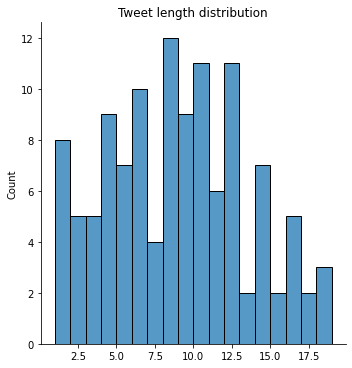

In [13]:
# Outlier review stats

tweet_lens = Counter([len(x) for x in tweetDf['processed_tweets']])
dct = dict(tweet_lens)
sns.displot(dct, binwidth=1).set(title='Tweet length distribution')
print("Zero-length reviews: {}".format(tweet_lens[0]))
print("Maximum review length: {}".format(max(tweet_lens)))
print("Average review length: ",int(mean([x for x,y in tweet_lens.items()])))

In [14]:
le = LabelEncoder() 
le.fit(tweetDf['target'])    # change string to number for categories
tweetDf['target'] = le.transform(tweetDf['target'])
tweetDf.head(5)
glove_25 = vocab.Vectors(r"./glove.twitter.27B.25d.txt")
glove_100 = vocab.Vectors(r"./glove.twitter.27B.100d.txt")
tweetDf.drop(columns=['tweet','text'],inplace=True)
vector_length = 100
glove_length  = 25
glove_package = glove_25

100%|█████████▉| 1193513/1193514 [00:51<00:00, 22953.77it/s]


In [15]:
text_field = Field(tokenize=nltk.word_tokenize,lower=True,fix_length = vector_length,sequential=True) # tokenize text using word_tokenize and convert to numerical form using default parameters
label_field = Field(sequential=False, use_vocab=False)

fields = [('target',label_field),('processed_tweets',text_field)]

preprocessed_text = tweetDf['processed_tweets'].apply(lambda x: text_field.preprocess(x))
text_field.build_vocab(preprocessed_text,vectors=glove_package)

In [16]:
from torchtext.data import Dataset, Example
train_dataset,validation_dataset,test_dataset = Dataset(
    examples=[Example.fromlist(list(r),fields) for i,r in tweetDf.iterrows()],
    fields=fields).split(split_ratio=[0.8,0.1,0.1])

In [17]:
def train_and_validate(net,epochs,loss_function,optimizer,scheduler,args):

  train_loss, train_acc = [], []
  val_loss_list, val_acc_list = [], []

  # number of epochs
  if(train_on_gpu):
    net.cuda()

  for e in range(epochs):
    
    running_loss = 0.0
    running_acc = 0.0
    counter = 0
    val_loss = 0.0
    val_acc = 0.0
    
    # ------------- TRAIN --------------
    net.train()    
    for batch in train_loader:
        counter += 1
        
        if(train_on_gpu):
            batch.processed_tweets, batch.target = batch.processed_tweets.cuda(), batch.target.cuda()

        optimizer.zero_grad()
        # print("-- ",batch.processed_tweets.shape)
        y_pred = net(batch.processed_tweets.T)

        if(train_on_gpu):
          y_pred = y_pred.squeeze().cuda()
          target = batch.target.float().cuda()
        else:
          y_pred = y_pred.squeeze()
          target = batch.target.float()

        l = loss_function(y_pred, target)
        running_loss += (l.item() - running_loss) / (counter)

        l.backward()

        # Clip gradients
        if args.gradient_clip != None:
          for param in net.parameters():
              if param.grad is None:
                  continue
              grad_val = torch.clamp(param.grad, -args.gradient_clip, args.gradient_clip)

        # apply gradients
        optimizer.step()

        acc_t = accuracy_score(batch.target.cpu().numpy(),torch.round(y_pred).cpu().detach().numpy())*100
        running_acc += (acc_t - running_acc) / (counter)


    train_loss.append(running_loss)
    train_acc.append(running_acc)

    # -------------- VALIDATE --------------

    epoch_loss = 0.0
    counter = 0
    with torch.no_grad():
        # Faster inference
        net.eval()


    for batch in valid_loader:
      
      counter += 1

      if(train_on_gpu):
        batch.processed_tweets, batch.target = batch.processed_tweets.cuda(), batch.target.cuda()
  
      y_pred = net.forward(batch.processed_tweets.T)

      if(train_on_gpu):
        y_pred = y_pred.squeeze().cuda()
        target = batch.target.float().cuda()
      else:
        y_pred = y_pred.squeeze()
        target = batch.target.float()

      l = loss_function(y_pred, target)

      val_loss += (l.item() - val_loss) / (counter)
      # y_pred = torch.round(y_pred)
      acc_t = accuracy_score(batch.target.cpu().numpy(),torch.round(y_pred).cpu().detach().numpy())*100
      val_acc += (acc_t - val_acc) / (counter)

    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    if scheduler != None:
      scheduler.step(val_loss_list[-1])
    print(f'Epoch {(e+1)+0:03} | Train_Loss: {running_loss:.5f} | Train_Acc: {running_acc:.3f} | Val_Loss: {val_loss:.3f} | Val_Acc: {val_acc:.3f}')
  
  print()
  print("TRAIN STATS:")
  print("Train mean loss: {:.6f} ".format(np.mean(train_loss)))
  print("Train mean acc: {:.6f}".format(np.mean(train_acc)))
  print()
  print("VALIDATION STATS:")
  print("Validation mean loss: {:.6f} ".format(np.mean(val_loss)))
  print("Validation mean acc: {:.6f}".format(np.mean(val_acc)))     

  return train_loss,train_acc,val_loss_list,val_acc_list

In [18]:
def test(net,test_loader,loss_function):
  running_loss = 0.0
  score_accuracy = []
  score_f1 = []
  score_precision = []
  score_recall = []
  counter = 0

  net.eval()
  for batch in test_loader:
      counter += 1

      if(train_on_gpu):
        batch.processed_tweets, batch.target = batch.processed_tweets.cuda(), batch.target.cuda()
  
      y_pred = net.forward(batch.processed_tweets.T)

      if(train_on_gpu):
        batch.processed_tweets, batch.target = batch.processed_tweets.cpu(), batch.target.cpu()

      y_pred = torch.round(y_pred).cpu()
      score_f1.append(f1_score(batch.target.numpy(),y_pred.detach().numpy()))
      score_accuracy.append(accuracy_score(batch.target.numpy(),y_pred.detach().numpy()))
      score_recall.append(recall_score(batch.target.numpy(),y_pred.detach().numpy()))
      score_precision.append(precision_score(batch.target.numpy(),y_pred.detach().numpy()))
      
  print("F1:        {:.6f}".format(np.mean(score_f1)*100))
  print("Recall:    {:.6f}".format(np.mean(score_recall)*100))
  print("Precision: {:.6f}".format(np.mean(score_precision)*100))
  print("Accuracy:  {:.6f}".format(np.mean(score_accuracy)*100))

In [19]:
class RNN_TweetClassifier(nn.Module):
    def __init__(self, cell_type, input_size, output_size, vocab_size, embedding_dim, hidden_size,num_layers, num_classes=1,hidden_dim=200,hidden_size1 = 500,hidden_size2 = 100, embedding=None ,bidirectional=True ,dropout_prob=0.2):
        super(RNN_TweetClassifier,self).__init__()


        cells = {
          "RNN"     : nn.RNN,
          "LSTM"    : nn.LSTM,
          "GRU"     : nn.GRU
        }

        self.cell_type = cell_type
        self.dropout_prob = dropout_prob
        self.input_size, self.output_size, self.hidden_size, self.vocab_size, self.embedding_dim ,self.num_layers = input_size, output_size, hidden_size, vocab_size, embedding_dim, num_layers
        self.bidirectional = bidirectional

        # self.embedding = embedding  # or better
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding),padding_idx=0)
        
        self.rnn = cells[cell_type](         # Pick the specific model
            input_size=embedding_dim,          # Number of features for each time step
            hidden_size=hidden_size,         # Rnn hidden embedding representation
            num_layers=num_layers,           # Number of layers (if >1 it is a stacked RNN)
            bidirectional=bidirectional,     # If true it is a 
            batch_first=True,                # input & output will have batch size as 1st dimension. e.g. (batch, time_step, input_size)
            dropout = dropout_prob if dropout_prob != None else 0,

        )        

        if dropout_prob != None:
          self.dropout = nn.Dropout(p = dropout_prob)

        if bidirectional == True:
          self.fc1 = nn.Linear(hidden_size*2 , output_size)        
        else:
          self.fc1 = nn.Linear(hidden_size , output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        
        # print('x shape:', x.shape)
        # out = self.embedding[x].reshape(x.size()[0], -1) or better
        out = self.embedding(x)
        
        if self.dropout_prob != None:
          out = self.dropout(out)

        # print('out shape:', out.shape) 
        if self.cell_type == 'LSTM':
            r_out, (last_hidden_state, last_cell_state) = self.rnn(out.detach()) 
        else:
            r_out, last_hidden_state = self.rnn(out.detach())

        r_out = r_out[:, -1, :]
        out = self.fc1(r_out) 
        out = self.sigmoid(out)

        return out

In [20]:
from argparse import Namespace
from torch.optim import Adam
import time

args = Namespace(
    gradient_clip = 2,
)
batch_size= 100
learning_rate = 0.01
epochs = 10
loss_function = nn.BCELoss()

args.gradient_clip = None

## 1. Vanilla RNN
![vanilla_RNN](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)


- Vanilla RNN can be implemented with ```torch.nn.RNN()``` 

- Key Parameters
  - ```input_size```:  number of expected features in the input (i.e., dimensionality of feature space)
  - ```hidden_size```: number of features in hidden state (i.e., dimensionality of output space)
  - ```num_layers```: number of recurrent layers (to create stacked RNN)
  - ```batch_first```: If ```True```, input and output tensor shapes are ```(batch_size, seq_length, dim_feature)```. If ```False```, ```(sequence_length, batch_size, dim_feature)```
  - ```bidirectional```: If ```True```, bidirectional RNN
  
- One thing to note is that unlike fully-connected layers or convolutional layers, RNNs take multi inputs/outputs
  - In addition to (sequential) inputs, RNN has another called hidden state, which makes RNN special
  - This hidden state sends information regarding current step to the next\
  
- Inputs to RNN: ```(x0, h0)```
  - ```x0```: tensor that contains features of the input sequence
    - shape
      - ```(seq_len, batch_size, input_size)``` if ```batch_first == False``` (default)
      - ```(batch_size, seq_len, input_size)``` if ```batch_fist == True``` 
  - ```h0```: tensor that contains hidden state for each instance
    - shape
      - ```(num_layers * num_directions, batch_size, hidden_size)```

In [21]:
cell = 'RNN'
hidden_sizes = [64,128,256, 512]

for hidden_size in hidden_sizes:
    print("\n---------  ",cell," | ",hidden_size,"  ------------ \n")
    net = RNN_TweetClassifier(
        vocab_size = len(text_field.vocab),
        embedding_dim = glove_length,
        input_size = vector_length,
        hidden_size = hidden_size,
        output_size = 1,
        num_layers = 2,
        bidirectional = True,
        cell_type = cell,
        embedding = text_field.vocab.vectors,
        dropout_prob = 0.2
    )
    net
    learning_rate = 0.01
    epochs = 10
    loss_function = nn.BCELoss()
    optimizer =  Adam(net.parameters(),lr = learning_rate)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    args.gradient_clip = 2

    train_loader, valid_loader, test_loader = BucketIterator.splits(
    datasets=(train_dataset,validation_dataset ,test_dataset), 
    batch_sizes=(batch_size,batch_size,batch_size),
    sort=False,
    device = 'cuda' if train_on_gpu else 'cpu',)

    train_loss,train_acc,val_loss,val_acc = train_and_validate(net,epochs,loss_function,optimizer,lr_scheduler,args)

    #net = Model_RNN.to(device)
    print(f"Test stats: ")
    test(net,test_loader,loss_function)

    print("\n\n")


---------   RNN  |  64   ------------ 

Epoch 001 | Train_Loss: 0.71594 | Train_Acc: 52.500 | Val_Loss: 0.700 | Val_Acc: 51.000
Epoch 002 | Train_Loss: 0.69987 | Train_Acc: 48.125 | Val_Loss: 0.693 | Val_Acc: 50.000
Epoch 003 | Train_Loss: 0.71931 | Train_Acc: 47.000 | Val_Loss: 0.731 | Val_Acc: 46.000
Epoch 004 | Train_Loss: 0.70127 | Train_Acc: 51.875 | Val_Loss: 0.680 | Val_Acc: 59.000
Epoch 005 | Train_Loss: 0.71303 | Train_Acc: 47.500 | Val_Loss: 0.716 | Val_Acc: 47.000
Epoch 006 | Train_Loss: 0.69838 | Train_Acc: 49.750 | Val_Loss: 0.710 | Val_Acc: 49.000
Epoch 007 | Train_Loss: 0.69723 | Train_Acc: 52.500 | Val_Loss: 0.702 | Val_Acc: 40.000
Epoch 008 | Train_Loss: 0.69144 | Train_Acc: 52.750 | Val_Loss: 0.728 | Val_Acc: 49.000
Epoch 009 | Train_Loss: 0.69575 | Train_Acc: 54.125 | Val_Loss: 0.714 | Val_Acc: 48.000
Epoch 010 | Train_Loss: 0.69358 | Train_Acc: 50.500 | Val_Loss: 0.713 | Val_Acc: 49.000

TRAIN STATS:
Train mean loss: 0.702580 
Train mean acc: 50.662500

VALIDATION 

## 2. Gated Recurrent Units (GRU)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Gated_Recurrent_Unit%2C_base_type.svg/780px-Gated_Recurrent_Unit%2C_base_type.svg.png)

- GRU has rather complicated structure compared to vanilla RNN (see below figure), but in terms of implementing it with Pytorch, largely similar to RNN, using ```torch.nn.GRU```

In [22]:
cell = 'GRU'
hidden_sizes = [64,128,256, 512]

for hidden_size in hidden_sizes:
    print("\n---------  ",cell," | ",hidden_size,"  ------------ \n")
    net = RNN_TweetClassifier(
        vocab_size = len(text_field.vocab),
        embedding_dim = glove_length,
        input_size = vector_length,
        hidden_size = hidden_size,
        output_size = 1,
        num_layers = 2,
        bidirectional = True,
        cell_type = cell,
        embedding = text_field.vocab.vectors,
        dropout_prob = 0.2
    )
    net
    learning_rate = 0.01
    epochs = 10
    loss_function = nn.BCELoss()
    optimizer =  Adam(net.parameters(),lr = learning_rate)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    args.gradient_clip = 2

    train_loader, valid_loader, test_loader = BucketIterator.splits(
    datasets=(train_dataset,validation_dataset ,test_dataset), 
    batch_sizes=(batch_size,batch_size,batch_size),
    sort=False,
    device = 'cuda' if train_on_gpu else 'cpu',)

    train_loss,train_acc,val_loss,val_acc = train_and_validate(net,epochs,loss_function,optimizer,lr_scheduler,args)

    #net = Model_RNN.to(device)
    print(f"Test stats: ")
    test(net,test_loader,loss_function)

    print("\n\n")


---------   GRU  |  64   ------------ 

Epoch 001 | Train_Loss: 0.70055 | Train_Acc: 51.375 | Val_Loss: 0.694 | Val_Acc: 51.000
Epoch 002 | Train_Loss: 0.69140 | Train_Acc: 53.500 | Val_Loss: 0.695 | Val_Acc: 51.000
Epoch 003 | Train_Loss: 0.69161 | Train_Acc: 53.500 | Val_Loss: 0.694 | Val_Acc: 51.000
Epoch 004 | Train_Loss: 0.69112 | Train_Acc: 53.500 | Val_Loss: 0.694 | Val_Acc: 51.000
Epoch 005 | Train_Loss: 0.69114 | Train_Acc: 53.500 | Val_Loss: 0.694 | Val_Acc: 51.000
Epoch 006 | Train_Loss: 0.69129 | Train_Acc: 53.500 | Val_Loss: 0.694 | Val_Acc: 51.000
Epoch 007 | Train_Loss: 0.69101 | Train_Acc: 53.500 | Val_Loss: 0.695 | Val_Acc: 51.000
Epoch 008 | Train_Loss: 0.69209 | Train_Acc: 53.500 | Val_Loss: 0.693 | Val_Acc: 51.000
Epoch 009 | Train_Loss: 0.69083 | Train_Acc: 53.500 | Val_Loss: 0.694 | Val_Acc: 51.000
Epoch 010 | Train_Loss: 0.69085 | Train_Acc: 53.500 | Val_Loss: 0.695 | Val_Acc: 51.000

TRAIN STATS:
Train mean loss: 0.692190 
Train mean acc: 53.287500

VALIDATION 

## 3. Long Short Term Memory (LSTM)

![](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/The_LSTM_cell.png/1200px-The_LSTM_cell.png)

- LSTM is another variant of vanilla RNN that is widely used. Though there exist some differences in structure, when implementing one just need to attend to the cell state (c_t)
  - Inputs to LSTM: (x0, (h0, c0)
    - ```x0```: tensor that contains features of the input sequence
      - shape: ```(seq_len, batch_size, input_size)```
    - ```h0```: tensor that contains initial hidden state
      - shape: ```(num_layers * num_directions, batch_size, hidden_size)```
    - ```c0```: tensor that contains initial cell state
      - shape: ```(num_layers * num_directions, batch_size, hidden_size)``` (same as h0)
  - Outputs to LSTM: (xn, (hn, cn))
    - ```xn```: tensor that contains output features from the last layer
      - shape: ```(seq_len, batch_size, num_directions * hidden_size)```
    - ```hn```: tensor containing the hidden state
      - shape: ```(num_layers * num_directions, batch_size, hidden_size)```
    - ```cn```: tensor containing the cell state
      - shape: ```(num_layers * num_directions, batch_size, hidden_size)```

In [ ]:
cell = 'LSTM'
hidden_sizes = [64,128,256, 512]

for hidden_size in hidden_sizes:
    print("\n---------  ",cell," | ",hidden_size,"  ------------ \n")
    net = RNN_TweetClassifier(
        vocab_size = len(text_field.vocab),
        embedding_dim = glove_length,
        input_size = vector_length,
        hidden_size = hidden_size,
        output_size = 1,
        num_layers = 2,
        bidirectional = True,
        cell_type = cell,
        embedding = text_field.vocab.vectors,
        dropout_prob = 0.2
    )
    net
    learning_rate = 0.01
    epochs = 10
    loss_function = nn.BCELoss()
    optimizer =  Adam(net.parameters(),lr = learning_rate)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    args.gradient_clip = 2

    train_loader, valid_loader, test_loader = BucketIterator.splits(
    datasets=(train_dataset,validation_dataset ,test_dataset), 
    batch_sizes=(batch_size,batch_size,batch_size),
    sort=False,
    device = 'cuda' if train_on_gpu else 'cpu',)

    train_loss,train_acc,val_loss,val_acc = train_and_validate(net,epochs,loss_function,optimizer,lr_scheduler,args)

    #net = Model_RNN.to(device)
    print(f"Test stats: ")
    test(net,test_loader,loss_function)

    print("\n\n")


---------   LSTM  |  64   ------------ 

Epoch 001 | Train_Loss: 0.69303 | Train_Acc: 52.000 | Val_Loss: 0.694 | Val_Acc: 51.000
Epoch 002 | Train_Loss: 0.69147 | Train_Acc: 53.500 | Val_Loss: 0.695 | Val_Acc: 51.000
Epoch 003 | Train_Loss: 0.69141 | Train_Acc: 53.500 | Val_Loss: 0.695 | Val_Acc: 51.000
Epoch 004 | Train_Loss: 0.69110 | Train_Acc: 53.500 | Val_Loss: 0.693 | Val_Acc: 51.000
Epoch 005 | Train_Loss: 0.69119 | Train_Acc: 53.500 | Val_Loss: 0.694 | Val_Acc: 51.000
Epoch 006 | Train_Loss: 0.69116 | Train_Acc: 53.500 | Val_Loss: 0.694 | Val_Acc: 51.000
Epoch 007 | Train_Loss: 0.69099 | Train_Acc: 53.500 | Val_Loss: 0.695 | Val_Acc: 51.000
Epoch 008 | Train_Loss: 0.69245 | Train_Acc: 53.500 | Val_Loss: 0.693 | Val_Acc: 51.000
Epoch 009 | Train_Loss: 0.69081 | Train_Acc: 53.500 | Val_Loss: 0.694 | Val_Acc: 51.000
Epoch 010 | Train_Loss: 0.69071 | Train_Acc: 53.500 | Val_Loss: 0.695 | Val_Acc: 51.000

TRAIN STATS:
Train mean loss: 0.691433 
Train mean acc: 53.350000

VALIDATION